In [ ]:
# Basic imports
import os
import sys
import pickle
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')
sys.path.insert(0, './src')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from missforest import MissForest

# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div

# Custom modules
from src.gain import *
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features, miss_mask = data["df_select_features"], data["miss_mask"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness, select_MRIvolume, select_PET = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

df_X = df_X[miss_mask]
df_y = df_y[miss_mask]
df_all = df_all[miss_mask]

# List Imputers

In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

# Compute imputed data distributions

In order to have a look at the features imputed by our different algorithms, we will just impute some of the data with the different algorithms on the training set with all the missing values to see if the distributions of imputed data do not diverge too much from the original ones. 

In [ ]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [ ]:
df_X_imputed_list = {"Original" : df_X_train}

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

imputed_filename = "dict_imputed_df_X"

file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

if os.path.exists(file_path):
    print(f"The file '{imputed_filename}' already exists'.")
    with open(file_path, "rb") as file: 
        df_X_imputed_list = pd.read_pickle(file)
else:

    for imputer_name, continuous_imputer in continuous_imputer_list: 
        df_X_imputed = df_X_train.copy()

        continuous_imputer.fit(df_X_train[continuous_features])
        
        df_X_imputed[continuous_features] = continuous_imputer.transform(df_X_train[continuous_features])
        df_X_imputed_list[imputer_name] = df_X_imputed

    file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

    with open(file_path, 'wb') as file:
        pickle.dump(df_X_imputed_list, file)
    print(f"The dictionary has been saved as '{imputed_filename}.pkl' in the folder ''.")

The file 'dict_imputed_df_X' already exists'.


In [ ]:
cols_to_check = ['ABETA', 'TAU', 'PTAU', 'ARG1', 'CD300E', 'CLU']

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())

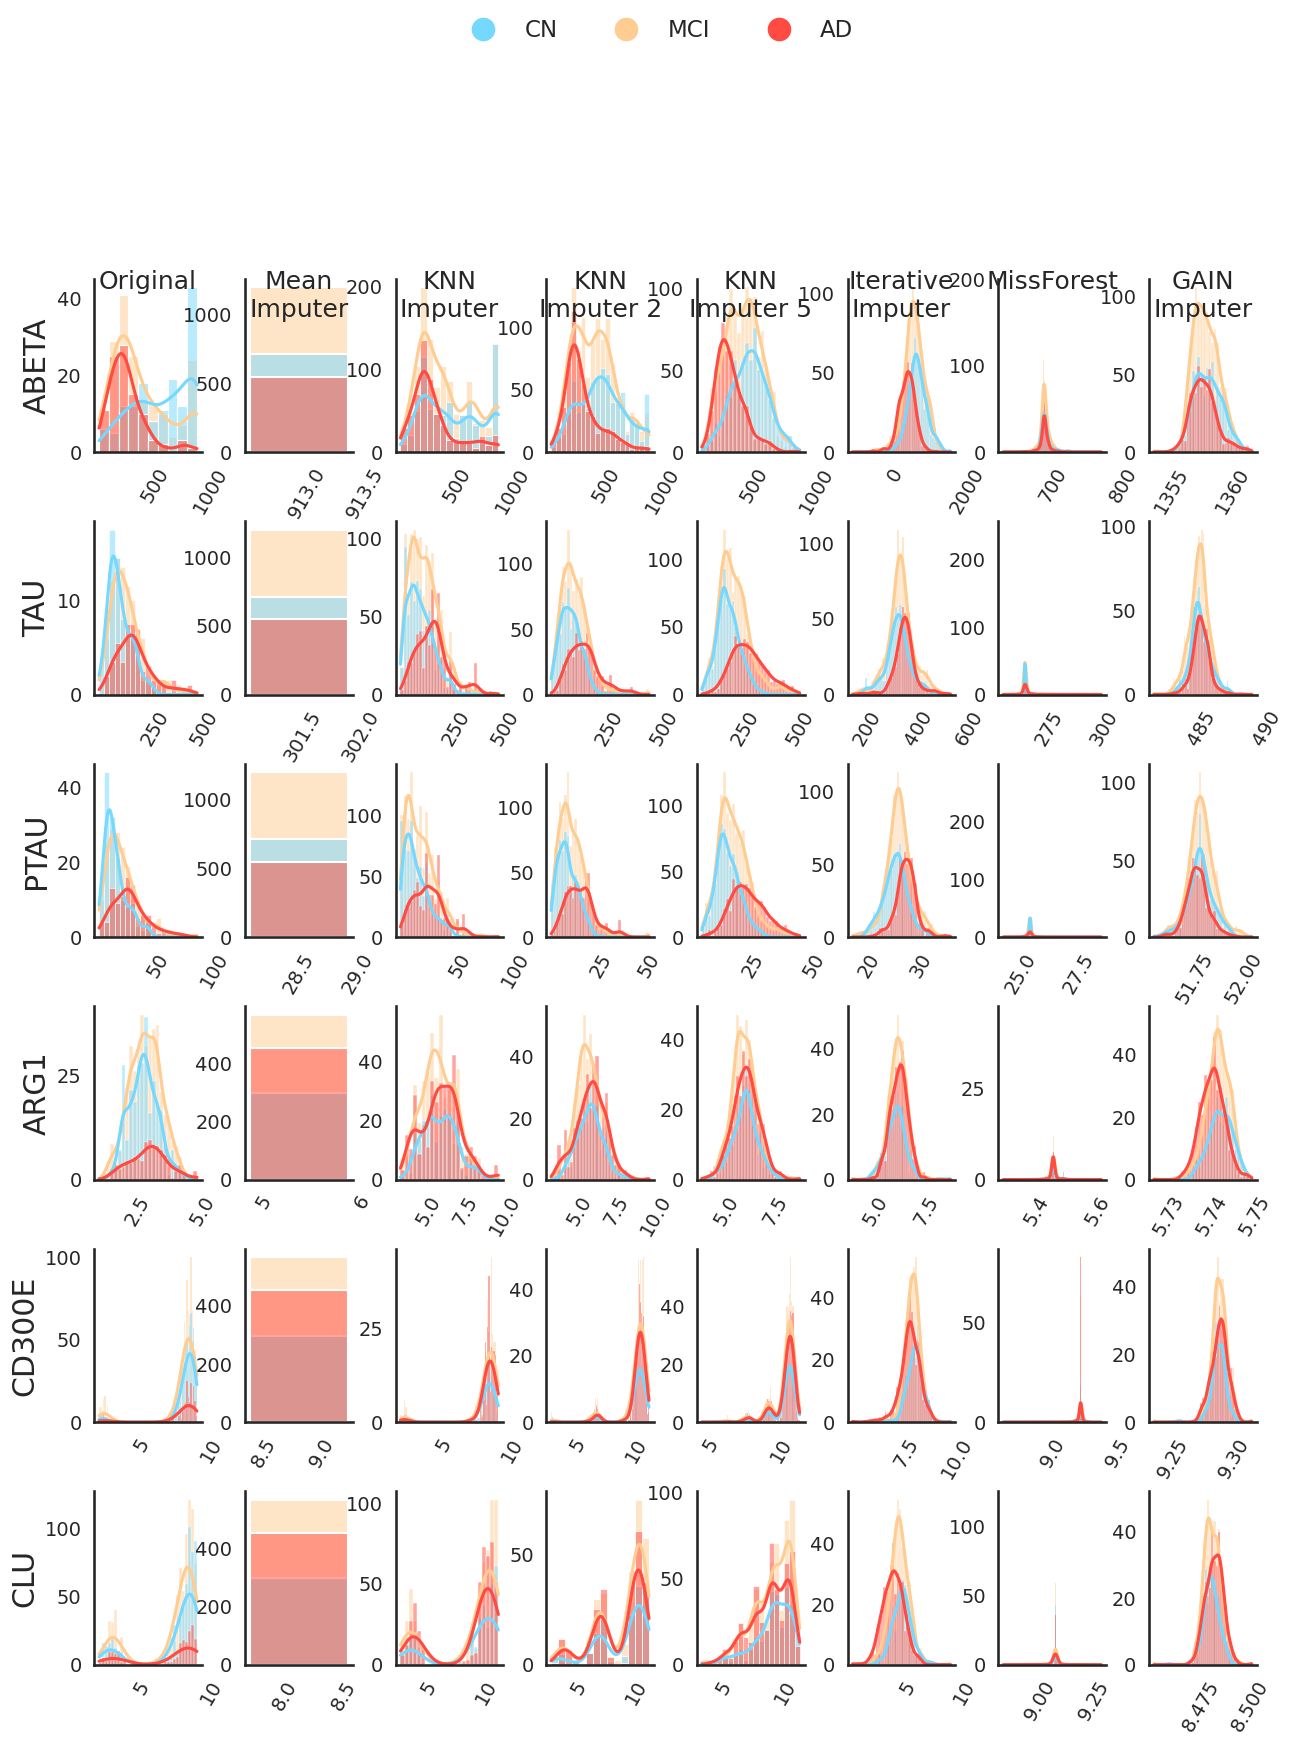

In [ ]:
hue_col = df_all.DX[idx_train]
palette = dx_palette

sns.set_style("white")
sns.set_context("talk")

df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=len(imputed_X_lst), figsize=(15, 18))

original_ticks = {}

for i, plot_X in enumerate(imputed_X_lst):
    for j, col in enumerate(cols_to_check):

        if imputed_name_lst[i] != "Original":
            plot_X_filtered = plot_X[df_X0[col].isna()]
        else:
            plot_X_filtered = plot_X
            original_ticks[col] = [
                np.floor(plot_X[col].min()),
                np.floor((plot_X[col].min() + plot_X[col].max()) / 2),
                np.ceil(plot_X[col].max()),
            ]

        sns.histplot(
            plot_X_filtered,
            x=col,
            hue=hue_col,
            ax=axes[j][i],
            palette=palette,
            kde=(imputed_name_lst[i] != "SimpleImputer_mean"),
            legend=False,
        )

        axes[j][i].set_xlabel("")
        axes[j][i].set_ylabel("")
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha="left", fontsize=14)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha="right", fontsize=14)
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=0)

        sns.despine()

# Set column titles
for ax, col in zip(axes[0], imputed_name_lst):
    ax.set_title(
        col.replace("SimpleImputer_mean", "MeanImputer")
        .replace("_", " ")
        .replace("Imputer", "\nImputer")
        .replace("(", "\n("),
        fontdict={"verticalalignment": "top"},
    )

# Set row labels
for ax, col in zip(axes[:, 0], cols_to_check):
    ax.set_ylabel(col.replace("_", " "), rotation=90, size="large")

# Add legend if a palette is defined
if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker="o", linestyle="", markersize=16, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.0),
        ncol=len(palette),
        title="",
        frameon=False,
    )

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches="tight")


In [ ]:
df_X_imputed_list
features_of_interest=cols_to_check
savefolder = "../figures/imputation"
heatmap_annot=True

original_df = df_X_imputed_list['Original']
ks_stats = {}
p_values = {}
kl_divergences = {}

In [ ]:
def compute_ecdf_stats(original_df, df_X_imputed_list, features_of_interest):
    from scipy.stats import ks_2samp, entropy as kl_div

    ks_stats = {}
    p_values = {}
    kl_divergences = {}
    ecdf_data_dict = {}

    for feature_name in features_of_interest:
        ks_stats[feature_name] = {}
        p_values[feature_name] = {}
        kl_divergences[feature_name] = {}

        original_clean = original_df[feature_name].dropna()
        missing_indices = original_df[feature_name].isna()

        ecdf_data = pd.DataFrame()

        for method, imputed_df in df_X_imputed_list.items():
            if method == 'Original':
                continue

            imputed_values = imputed_df.loc[missing_indices, feature_name]

            # KS test
            ks_stat, p_value = ks_2samp(original_clean, imputed_values)
            ks_stats[feature_name][method] = ks_stat
            p_values[feature_name][method] = p_value

            # KL divergence
            bins = np.histogram_bin_edges(original_clean, bins="fd")
            original_hist, _ = np.histogram(original_clean, bins=bins, density=True)
            imputed_hist, _ = np.histogram(imputed_values, bins=bins, density=True)

            original_hist += 1e-9
            imputed_hist += 1e-9

            kl_value = np.sum(kl_div(original_hist, imputed_hist))
            kl_divergences[feature_name][method] = kl_value

            # Prepare ECDF
            temp_df = pd.DataFrame({
                'Value': np.sort(imputed_values),
                'ECDF': np.arange(len(imputed_values)) / len(imputed_values),
                'Method': method
            })
            ecdf_data = pd.concat([ecdf_data, temp_df], ignore_index=True)

        # Add ECDF for original
        original_ecdf = pd.DataFrame({
            'Value': np.sort(original_clean),
            'ECDF': np.arange(len(original_clean)) / len(original_clean),
            'Method': 'Original'
        })
        ecdf_data = pd.concat([ecdf_data, original_ecdf], ignore_index=True)

        ecdf_data_dict[feature_name] = ecdf_data

    return ecdf_data_dict, ks_stats, p_values, kl_divergences


In [ ]:
# Compute all ECDFs and stats
ecdf_data_dict, ks_stats, p_values, kl_divs = compute_ecdf_stats(original_df, df_X_imputed_list, df_X_imputed_list["Original"].columns)

In [ ]:
def plot_ecdf_grid(ecdf_data_dict, features_of_interest, savefolder=None):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_style("white")
    sns.set_context("talk")

    selected_features = [f for f in features_of_interest if f in ecdf_data_dict]
    num_features = len(selected_features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 4))
    axes = axes.flatten()

    for i, feature_name in enumerate(selected_features):
        ecdf_data = ecdf_data_dict[feature_name]

        sns.lineplot(
            data=ecdf_data,
            x="Value",
            y="ECDF",
            hue="Method",
            ax=axes[i],
            palette=sns.color_palette("Set1"),
            linewidth=3,
            alpha=0.8
        )

        axes[i].set_title(feature_name)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('ECDF')
        axes[i].get_legend().remove()
        sns.despine()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global legend
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("SimpleImputer_mean", "MeanImputer")
                .replace("Imputer", " Imputer")
                .replace("_", " ")
                .replace("(", " (") for l in labels]

    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=min(len(labels), 4),
        title="Imputation Method",
        frameon=False,
        fontsize=16,
        title_fontsize=18
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])

    if savefolder is not None:
        plt.savefig(f"{savefolder}_ecdf_plot.png", format="png", bbox_inches='tight')

    plt.show()


KeyboardInterrupt: 

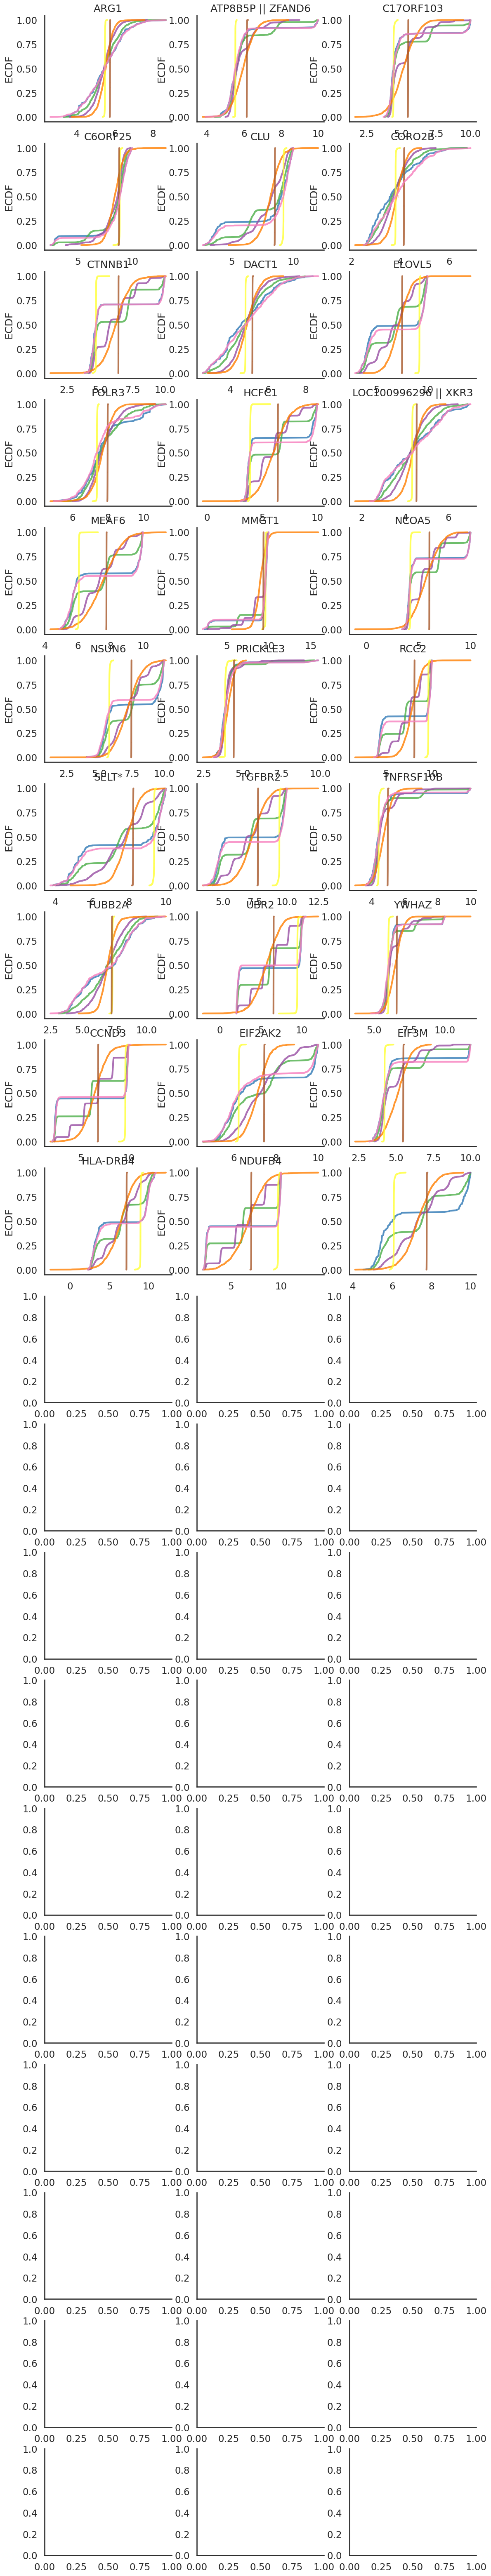

In [47]:
# Plot
plot_ecdf_grid(ecdf_data_dict, features_of_interest=ks_stats_df.index)

In [48]:
# Convert results to DataFrames for heatmaps
ks_stats_df = pd.DataFrame(ks_stats).T.dropna()
p_values_df = pd.DataFrame(p_values).T.dropna()
kl_divergences_df = pd.DataFrame(kl_divs).T.dropna()

In [49]:
def plot_metric_heatmap(
    metric_df,
    metric_name,
    features_of_interest=None,
    annotations_df=None,
    savefolder=None,
    cmap="vlag",
    vmin=None,
    vmax=None,
    cbar_ticks=None,
    figsize=(12, 6)
):
    """
    Plots a heatmap for a given metric (e.g., KS statistic, p-value, KL divergence).

    Parameters
    ----------
    metric_df : pd.DataFrame
        DataFrame with features as rows and imputation methods as columns.

    metric_name : str
        Name of the metric to use in the colorbar label and save name.

    features_of_interest : list of str, optional
        List of features to include in the heatmap. If None, include all.

    annotations_df : pd.DataFrame, optional
        DataFrame with annotations to display in the heatmap cells.

    savefolder : str, optional
        If provided, saves the plot with prefix to this folder.

    cmap : str
        Colormap for the heatmap.

    vmin, vmax : float
        Min/max values for color scaling.

    cbar_ticks : list of float, optional
        Tick marks for the colorbar.

    figsize : tuple
        Size of the heatmap figure.
    """
    # Subset features
    if features_of_interest is not None:
        metric_df = metric_df.loc[features_of_interest]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[features_of_interest]

    plt.figure(figsize=figsize)

    ax = sns.heatmap(
        metric_df.transpose(),
        annot=annotations_df.transpose() if annotations_df is not None else None,
        fmt=".2f" if annotations_df is not None else "",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': metric_name, 'ticks': cbar_ticks} if cbar_ticks else {'label': metric_name}
    )

    # Clean y-axis labels (methods)
    yticklabels = [
        label.get_text()
        .replace("SimpleImputer_mean", "MeanImputer")
        .replace("Imputer", " Imputer")
        .replace("_", " ")
        .replace("(", " (")
        for label in ax.get_yticklabels()
    ]
    ax.set_yticklabels(yticklabels)

    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Method")
    plt.xlabel("Feature")
    plt.tight_layout()

    if savefolder is not None:
        plt.savefig(f"{savefolder}_{metric_name.lower().replace(' ', '_')}_heatmap.png", format="png")

    plt.show()

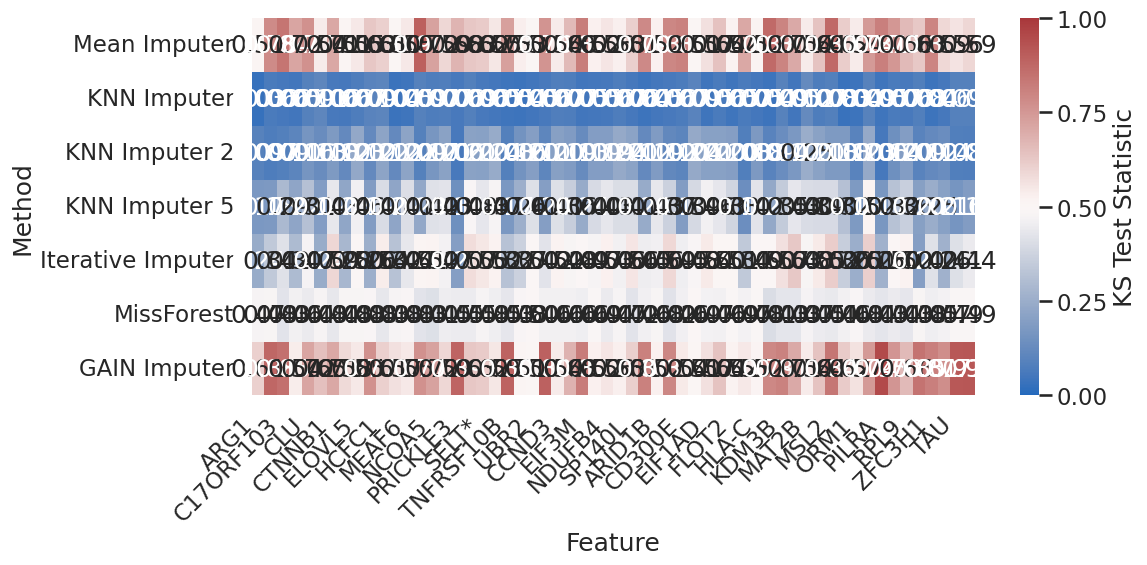

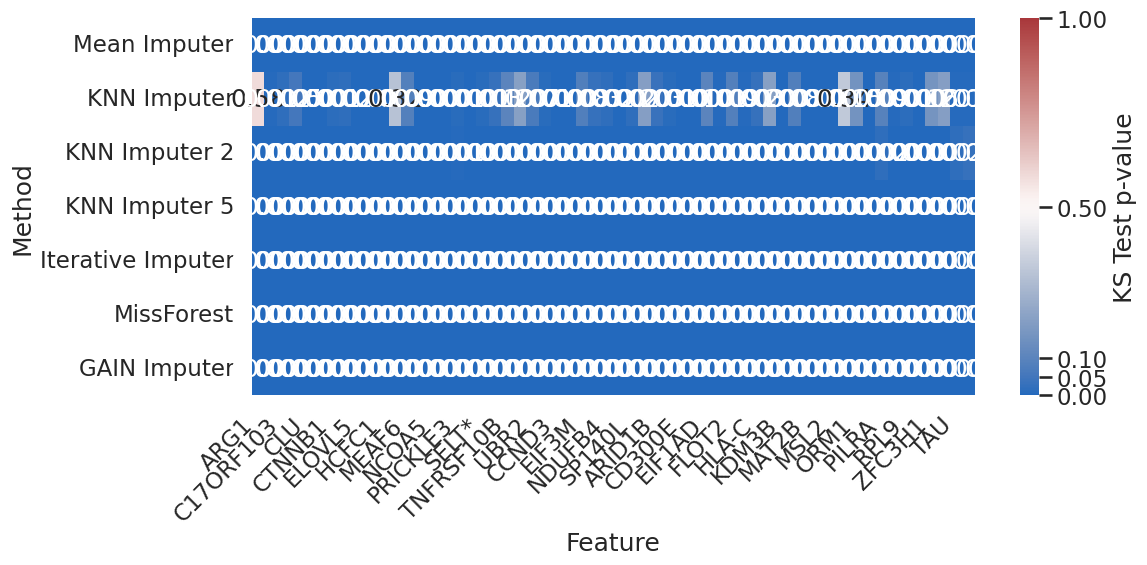

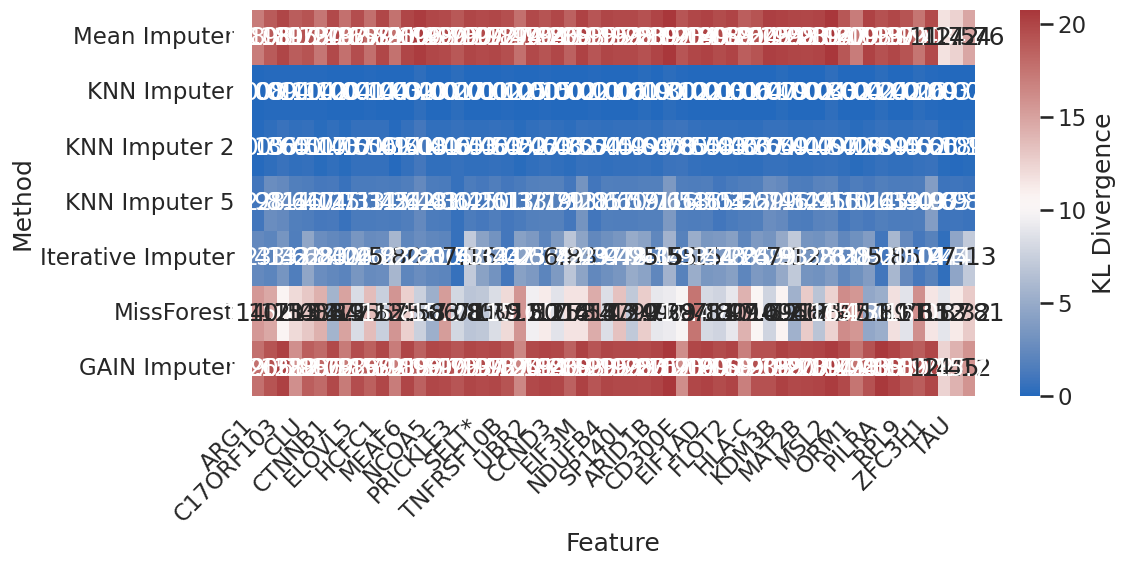

In [50]:
# KS Statistic
plot_metric_heatmap(
    metric_df=ks_stats_df,
    metric_name="KS Test Statistic",
    features_of_interest=ks_stats_df.index,
    annotations_df=ks_stats_df,
    savefolder=savefolder,
    cmap="vlag",
    vmin=0.0,
    vmax=1.0,
    cbar_ticks=[0.0, 0.25, 0.5, 0.75, 1.0]
)

# P-values
plot_metric_heatmap(
    metric_df=p_values_df,
    metric_name="KS Test p-value",
    features_of_interest=p_values_df.index,
    annotations_df=p_values_df,
    savefolder=savefolder,
    cmap="vlag",
    vmin=0.0,
    vmax=1.0,
    cbar_ticks=[0.0, 0.05, 0.1, 0.5, 1.0]
)

# KL Divergence
plot_metric_heatmap(
    metric_df=kl_divergences_df,
    metric_name="KL Divergence",
    features_of_interest=kl_divergences_df.index,
    annotations_df=kl_divergences_df,
    savefolder=savefolder,
    cmap="vlag",
    vmin=0.0,
    vmax=None  # Let seaborn scale automatically
)


### Order columns by KL divergence and KS test

In [51]:
kl_divergences_df.mean().sort_values()

KNNImputer             0.078040
KNNImputer_2           0.464278
KNNImputer_5           1.613784
IterativeImputer       3.399268
MissForest            10.813601
GAINImputer           18.985576
SimpleImputer_mean    19.040558
dtype: float64

In [52]:
p_values_df.mean().sort_values(ascending=False)

KNNImputer             5.860025e-02
KNNImputer_2           1.286428e-03
KNNImputer_5           1.991249e-10
IterativeImputer       4.252965e-24
MissForest             9.752288e-74
SimpleImputer_mean    7.143974e-108
GAINImputer           1.694411e-167
dtype: float64

In [53]:
ks_stats_df.mean().sort_values()

KNNImputer            0.064300
KNNImputer_2          0.155172
KNNImputer_5          0.319671
IterativeImputer      0.444833
MissForest            0.458314
SimpleImputer_mean    0.651387
GAINImputer           0.676846
dtype: float64

# Select preprocessing and transforms using Linear Regression as evaluation  model

In [31]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

Some of the patients with no missing values in the test set are present in the training set so we will remove them from training. 

In [32]:
set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

In [33]:
for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [34]:
sum(idx_train) + sum(idx_test) == df_X.shape[0]

True

In [35]:
df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

In [36]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

In [37]:
results_file = '../pickle/training_1_dict_results.pickle'

In [38]:
with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [39]:
if True: 

    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

    for continuous_imputer, ordinal_imputer, model in combinations:
        name_continuous_imputer, continuous_imputer_instance = continuous_imputer
        name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
        name_model, model_instance = model

        params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape
        }

        if any(result['params'] == params for result in all_dict_results):
            # Skip this iteration if the combination exists
            print(f"Skipping existing combination: {params.values()}")
            
            continue

        try: 
        
            # Now you can call your `train_model` function with these components
            dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

        except Exception as e:  

            print(e)
        
            dict_results = {
            "params": params, 
            "imputation_time": None,
            "fitting_time": None, 
            "results_adj": None, 
            "results_org": None
        }
            
        print(dict_results)
            
        # Optionally keep the all_dict_results list updated
        all_dict_results.append(dict_results)

            # Save the updated results back to the pickle file
        with open(results_file, 'wb') as f:
            pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer_2', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer_2', 'Linea

In [40]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('../pickle/training_1_dict_results.pickle', "rb") as input_file:
    dict_results_preprocessing = pickle.load(input_file)

In [42]:
df_results = pd.json_normalize(dict_results_preprocessing)

df_results.columns[df_results.columns.str.startswith("results")]

Index(['results_adj.mse_score', 'results_adj.mae_score', 'results_adj.r2',
       'results_adj.explained_variance', 'results_adj.corr',
       'results_org.mse_score', 'results_org.mae_score', 'results_org.r2',
       'results_org.explained_variance', 'results_org.corr', 'results_adj',
       'results_org'],
      dtype='object')

In [43]:
def missing_results_dict_to_dataframe(dict_output):

    df_results = pd.json_normalize(dict_output)

    for col in df_results.columns[df_results.columns.str.startswith("results")]:
        # Create new columns for each subcategory
        for i, subcategory in enumerate(df_y.columns):
            new_col_name = f"{col}.{subcategory}"
            df_results[new_col_name] = df_results[col].apply(lambda x: x[i] if x is not None else None)

            #print(new_col_name)

        # Optionally, drop the original list column
        df_results.drop(columns=col, inplace=True)

    # Show the expanded DataFrame
    return df_results

In [47]:
len(dict_results_preprocessing)

42

In [44]:
df_results_preprocess = missing_results_dict_to_dataframe(dict_results_preprocessing)

TypeError: 'float' object is not subscriptable

In [ ]:
df_results_preprocess_radar = df_results_preprocess.melt(id_vars=df_results_preprocess.columns[df_results_preprocess.columns.str.startswith("params")].tolist(), value_vars=df_results_preprocess.columns[df_results_preprocess.columns.str.startswith("results")].tolist())

df_results_preprocess_radar["variable"] = df_results_preprocess_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_preprocess_radar["result_domain"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_preprocess_radar["metric"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[1])
df_results_preprocess_radar["cognitive_domain"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_preprocess_radar = df_results_preprocess_radar.drop(columns=["variable"])

df_results_preprocess_radar["preprocessing"] =  df_results_preprocess_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
def df_results_radar_to_latex_pretable(df_results_preprocess_radar_, result_domain = "results_adj", scoring_metric="corr", ascending=True): 
        
        df_results_preprocess_to_latex = df_results_preprocess_radar_.drop(columns=["preprocessing", "params.train_shape", "params.test_shape"])

        df = df_results_preprocess_to_latex[df_results_preprocess_to_latex["result_domain"]== result_domain].drop(columns="result_domain")

        df_pivoted = df.pivot_table(index=['params.ordinal_imputer', 'params.continuous_imputer', 'params.model'],
                                    columns=['metric', 'cognitive_domain'],
                                    values='value',
                                    aggfunc='first')

        # Resetting index to flatten the MultiIndex
        df_pivoted.reset_index(inplace=True)
        # Flatten the MultiIndex columns temporarily for filtering
        df_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_pivoted.columns]

        # Select columns that start with 'params' or contain 'corr'
        columns_to_keep = [col for col in df_pivoted.columns if col.startswith('params') or scoring_metric in col]

        # Filter the dataframe
        df_filtered = df_pivoted[columns_to_keep]

        # Display the filtered dataframe
        # Add a column for the mean of each row
        # Select only the numeric columns (excluding 'params' columns)
        numeric_columns = df_filtered.select_dtypes(include='number').columns

        # Add a column for the mean of each row (across numeric columns)
        df_filtered['mean'] = df_filtered[numeric_columns].mean(axis=1)

        # Add a column for the standard deviation of each row (across numeric columns)
        df_filtered['std'] = df_filtered[numeric_columns].std(axis=1)

        return df_filtered.sort_values("mean", ascending=ascending)

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_preprocess_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
17,SimpleImputer_most_frequent,KNNImputer_2,LinearRegression,0.861,0.212,0.395,0.264,0.433,0.295
3,KNNImputer,KNNImputer_2,LinearRegression,0.860,0.206,0.379,0.274,0.430,0.296
10,SimpleImputer_constant,KNNImputer_2,LinearRegression,0.860,0.198,0.379,0.275,0.428,0.297
16,SimpleImputer_most_frequent,KNNImputer,LinearRegression,0.831,0.228,0.400,0.211,0.418,0.289
2,KNNImputer,KNNImputer,LinearRegression,0.831,0.222,0.383,0.219,0.414,0.289
18,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,0.824,0.169,0.341,0.315,0.412,0.285
9,SimpleImputer_constant,KNNImputer,LinearRegression,0.831,0.212,0.383,0.219,0.411,0.291
4,KNNImputer,KNNImputer_5,LinearRegression,0.824,0.164,0.326,0.326,0.410,0.287
11,SimpleImputer_constant,KNNImputer_5,LinearRegression,0.823,0.157,0.329,0.329,0.410,0.287
6,KNNImputer,SimpleImputer_mean,LinearRegression,0.844,0.180,0.304,0.195,0.381,0.314


In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_preprocess_radar, result_domain="results_adj", scoring_metric="mae_score")

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
16,SimpleImputer_most_frequent,KNNImputer,LinearRegression,0.527,0.799,0.767,0.650,0.686,0.124
2,KNNImputer,KNNImputer,LinearRegression,0.527,0.802,0.772,0.649,0.687,0.126
17,SimpleImputer_most_frequent,KNNImputer_2,LinearRegression,0.487,0.861,0.774,0.637,0.690,0.164
9,SimpleImputer_constant,KNNImputer,LinearRegression,0.528,0.808,0.776,0.648,0.690,0.128
3,KNNImputer,KNNImputer_2,LinearRegression,0.487,0.864,0.776,0.635,0.690,0.165
10,SimpleImputer_constant,KNNImputer_2,LinearRegression,0.489,0.870,0.782,0.634,0.694,0.168
20,SimpleImputer_most_frequent,SimpleImputer_mean,LinearRegression,0.462,0.884,0.836,0.670,0.713,0.191
6,KNNImputer,SimpleImputer_mean,LinearRegression,0.462,0.885,0.841,0.667,0.714,0.192
18,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,0.532,0.887,0.808,0.629,0.714,0.163
4,KNNImputer,KNNImputer_5,LinearRegression,0.531,0.889,0.810,0.626,0.714,0.164


In [ ]:
def plot_radar_plots_results(filtered_df): 

    # Rescale the values per metric
    scaler = MinMaxScaler(feature_range=(0, 1))

    filtered_df["scaled_value"] = filtered_df.groupby("metric")["value"].transform(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
    )

    # Get the unique preprocessing methods and define the color palette
    unique_preprocessing = filtered_df["preprocessing"].unique()
    color_map = sns.color_palette("husl", len(unique_preprocessing))  # Husl color palette
    # Convert Seaborn RGB colors to hex
    color_map_hex = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b in color_map]
    preprocessing_colors = {method: color_map_hex[i] for i, method in enumerate(unique_preprocessing)}

    # Get the unique cognitive domains
    cognitive_domains = filtered_df["cognitive_domain"].unique()

    # Create a subplot figure with 4 polar charts (2 rows x 2 columns)
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "polar"}, {"type": "polar"}], [{"type": "polar"}, {"type": "polar"}]],
        subplot_titles=cognitive_domains,
    )

    # Track which preprocessing methods have been added to the legend
    legend_added = set()

    # Plot each cognitive domain
    for i, domain in enumerate(cognitive_domains):
        # Filter data for the current cognitive domain
        domain_df = filtered_df[filtered_df["cognitive_domain"] == domain]
        
        # Add a polar chart for each preprocessing method in the current domain
        for preprocessing_method in domain_df["preprocessing"].unique():
            method_df = domain_df[domain_df["preprocessing"] == preprocessing_method]
            
            # Show legend only if this preprocessing method hasn't been added yet
            show_legend = preprocessing_method not in legend_added
            if show_legend:
                legend_added.add(preprocessing_method)
            
            fig.add_trace(
                go.Scatterpolar(
                    r=method_df["scaled_value"],
                    theta=method_df["metric"],
                    mode="lines+markers",
                    name=preprocessing_method,  # Label by preprocessing method
                    marker=dict(size=8),
                    line=dict(width=2, color=preprocessing_colors[preprocessing_method]),
                    customdata=method_df["value"],  # Original values for hover
                    hovertemplate="<b>Metric:</b> %{theta}<br><b>Original Value:</b> %{customdata}<br><b>Scaled Value:</b> %{r}",
                    showlegend=show_legend,  # Only show legend for the first occurrence
                ),
                row=(i // 2) + 1,  # Row position
                col=(i % 2) + 1,  # Column position
            )

    # Update layout
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, title="Scaled Value (0-1)")),
        showlegend=True,
        height=800,  # Adjust height
        width=800,   # Adjust width
        title_text="Radar Charts by Cognitive Domain",
    )

    fig.show()


In [ ]:
plot_radar_plots_results(df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_adj"])

In [ ]:
plot_radar_plots_results(df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_org"])

In [ ]:
df_plot_preprocessing_ajd = df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_adj"]
df_plot_preprocessing_org = df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_org"]

In [ ]:
# Assuming df_plot_preprocessing_org is your dataset
# Define the colors based on the earlier preprocessing_colors dictionary

def plot_plotly_scatter(df_plot_preprocessing): 

    unique_preprocessing = df_plot_preprocessing["preprocessing"].unique()
    color_map = sns.color_palette("husl", len(unique_preprocessing))  # Husl color palette
    color_map_hex = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b in color_map]
    preprocessing_colors = {method: color_map_hex[i] for i, method in enumerate(unique_preprocessing)}

    # Map the colors to a list corresponding to preprocessing order
    df_plot_preprocessing["color"] = df_plot_preprocessing["preprocessing"].map(preprocessing_colors)

    # Create the interactive plot
    fig = px.scatter(
        df_plot_preprocessing,
        x="cognitive_domain",   # Equivalent to Seaborn's x-axis
        y="value",              # Equivalent to Seaborn's y-axis
        color="preprocessing",  # Hue equivalent
        facet_col="metric",     # Separate subplots for each metric
        hover_data=["preprocessing", "value"],  # Add hover details
    )

    # Update color mapping with consistent colors
    fig.for_each_trace(lambda trace: trace.update(marker=dict(color=preprocessing_colors.get(trace.name))))

    # Update layout for better spacing
    fig.update_layout(
        height=600,  # Adjust height of the overall plot
        width=1000,  # Adjust width of the overall plot
        title="Interactive Version of Seaborn's Swarm Plot with Consistent Colors",
    )

    # Adjust axis settings
    fig.update_yaxes(title_text="Value", matches=None)  # Independent y-axis per subplot
    fig.update_xaxes(title_text="Cognitive Domain")

    # Display the plot
    fig.show()


In [ ]:
plot_plotly_scatter(df_plot_preprocessing_ajd)

In [ ]:
plot_plotly_scatter(df_plot_preprocessing_org)

In [ ]:
df_plot_preprocessing_org

,params.ordinal_imputer,params.continuous_imputer,params.model,params.train_shape,params.test_shape,value,result_domain,metric,cognitive_domain,preprocessing,color
420,SimpleImputer_most_frequent,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.177,results_org,mse_score,ADNI_MEM,SimpleImputer_most_frequent.SimpleImputer_mean,#F67088
421,KNNImputer,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.192,results_org,mse_score,ADNI_MEM,KNNImputer.SimpleImputer_mean,#F77553
422,SimpleImputer_constant,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.182,results_org,mse_score,ADNI_MEM,SimpleImputer_constant.SimpleImputer_mean,#DE8731
423,SimpleImputer_most_frequent,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.078,results_org,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,#C59331
424,KNNImputer,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.097,results_org,mse_score,ADNI_MEM,KNNImputer.KNNImputer,#B19B31
...,...,...,...,...,...,...,...,...,...,...,...
835,KNNImputer,KNNImputer_2,LinearRegression,"(2882, 261)","(12, 261)",0.186,results_org,corr,ADNI_LAN,KNNImputer.KNNImputer_2,#AD88F4
836,SimpleImputer_constant,KNNImputer_2,LinearRegression,"(2882, 261)","(12, 261)",0.178,results_org,corr,ADNI_LAN,SimpleImputer_constant.KNNImputer_2,#D375F4
837,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,"(2882, 261)","(12, 261)",0.134,results_org,corr,ADNI_LAN,SimpleImputer_most_frequent.KNNImputer_5,#F45DEB
838,KNNImputer,KNNImputer_5,LinearRegression,"(2882, 261)","(12, 261)",0.127,results_org,corr,ADNI_LAN,KNNImputer.KNNImputer_5,#F566C9
